In [1]:
from bluemira.balance_of_plant.steady_state import (
    BalanceOfPlant,
    H2OPumping,
    HePumping,
    NeutronPowerStrategy,
    ParasiticLoadStrategy,
    PredeterminedEfficiency,
    RadChargedPowerStrategy,
    SuperheatedRankine,
)
from bluemira.base.parameter import ParameterFrame


Let's set up a typical power balance model. We start by specifying some parameters we
want to use.

In [2]:
# fmt: off
default_params = ParameterFrame([
    ['P_fus_DT', 'D-T fusion power', 1995, 'MW', None, 'Input'],
    ['P_fus_DD', 'D-D fusion power', 5, 'MW', None, 'Input'],
    ['P_rad', 'Radiation power', 400, 'MW', None, 'Input'],
    ['P_hcd', "Heating and current drive power", 50, "MW", None, 'Input'],
    ['P_hcd_el', "Heating and current drive electrical power", 150, "MW", None, 'Input'],
    ['P_bb_decay', 'Blanket decay heat', 30, 'MW', None, 'Input'],
])
# fmt: on


We then weed to specify how we're going to treat the neutrons, radiation, and charged
particle loads. We do this by specifying "strategies".

In [3]:
neutron_power_strat = NeutronPowerStrategy(
    f_blanket=0.9,
    f_divertor=0.05,
    f_vessel=0.04,
    f_other=0.01,
    energy_multiplication=1.35,
)
rad_sep_strat = RadChargedPowerStrategy(
    f_core_rad_fw=0.9,
    f_sol_rad=0.75,
    f_sol_rad_fw=0.8,
    f_sol_ch_fw=0.8,
    f_fw_aux=0.09,
)


Now we to specify how the in-vessel components are being cooled, to calculate pumping
powers, and the balance of plant cycle design.

In [4]:
blanket_pump_strat = HePumping(8, 7.5, 300, 500, eta_isentropic=0.9, eta_electric=0.87)
bop_cycle = SuperheatedRankine(bb_t_out=500, delta_t_turbine=20)
divertor_pump_strat = H2OPumping(f_pump=0.05, eta_isentropic=0.99, eta_electric=0.87)


Maybe we don't have any good models to estimate some of the other parasitic loads. We
can set up a simple scaling with respect to a known reference point, by sub-classing
from the ABC and specifying some calculation in the `calculate` method.

In [5]:
class EUDEMOReferenceParasiticLoadStrategy(ParasiticLoadStrategy):
    def __init__(self):
        self.p_fusion_ref = 2037
        self.p_cryo = 44
        self.p_mag = 44
        self.p_t_plant = 15.5
        self.p_other = 31

    def calculate(self, p_fusion):
        """
        Because we were told to do this. Nobody trusts models.
        """
        f_norm = p_fusion / self.p_fusion_ref
        p_mag = f_norm * self.p_mag
        p_cryo = f_norm * self.p_cryo
        p_t_plant = f_norm * self.p_t_plant
        p_other = f_norm * self.p_other
        return p_mag, p_cryo, p_t_plant, p_other


parasitic_load_strat = EUDEMOReferenceParasiticLoadStrategy()


Now, we put everything together and build it

In [6]:
HCPB_bop = BalanceOfPlant(
    default_params,
    rad_sep_strat=rad_sep_strat,
    neutron_strat=neutron_power_strat,
    blanket_pump_strat=blanket_pump_strat,
    divertor_pump_strat=divertor_pump_strat,
    bop_cycle_strat=bop_cycle,
    parasitic_load_strat=parasitic_load_strat,
)
HCPB_bop.build()

/home/matti/miniforge3/envs/bluemira/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



And we can take a look...

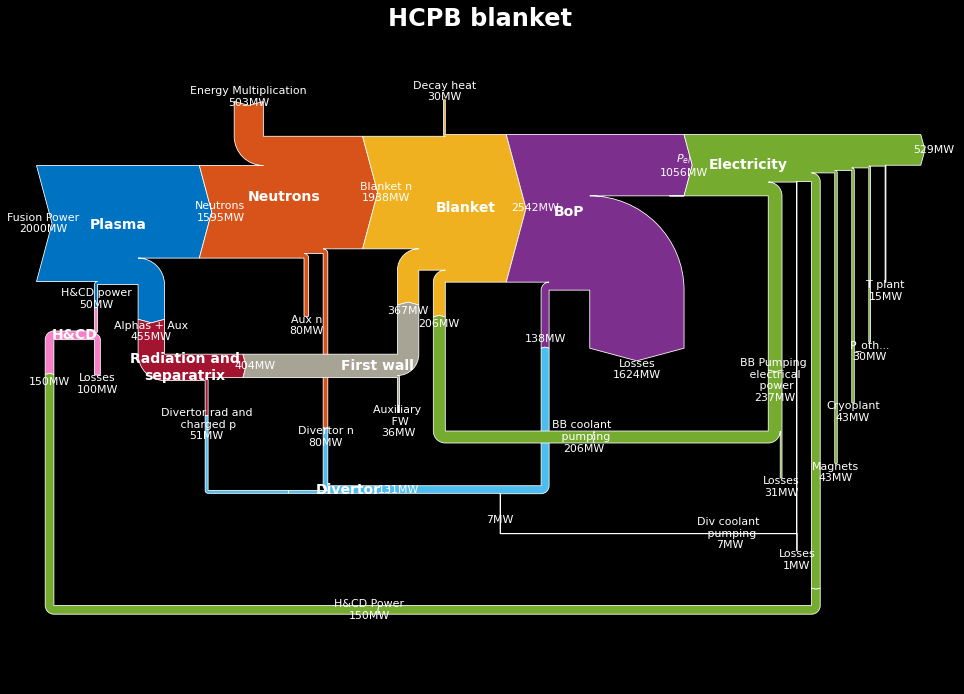

In [7]:
HCPB_bop.plot(title="HCPB blanket")


What about if we had a different blanket concept? The coolant is different, which means
the pumping loads will differ, and the power cycle will also be different. It's likely
that the energy multiplication is different too

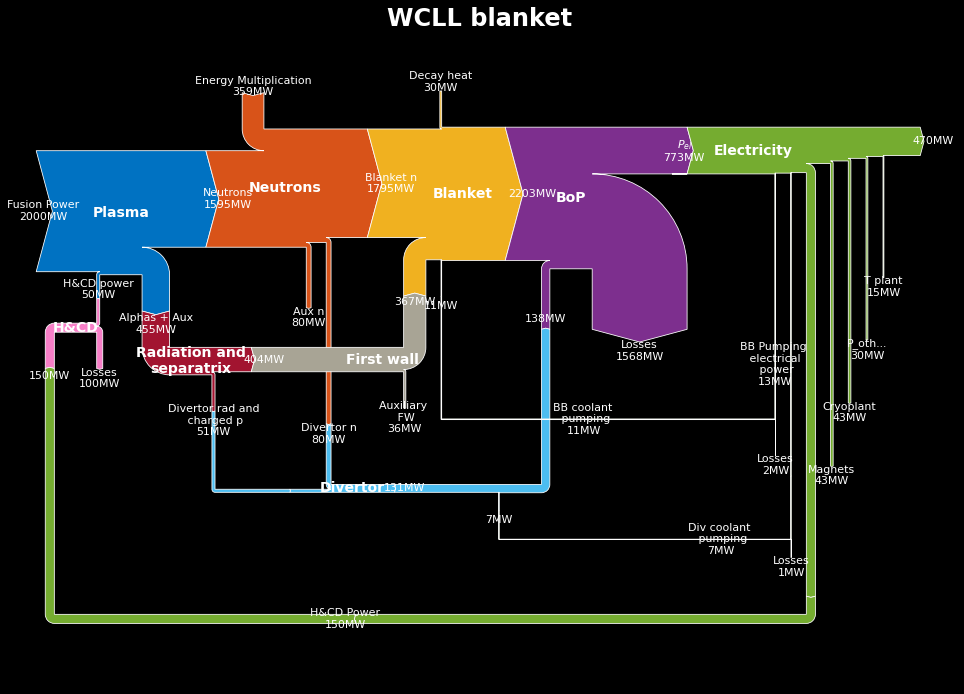

In [8]:
neutron_power_strat = NeutronPowerStrategy(
    f_blanket=0.9,
    f_divertor=0.05,
    f_vessel=0.04,
    f_other=0.01,
    energy_multiplication=1.25,
)
blanket_pump_strat = H2OPumping(0.005, eta_isentropic=0.99, eta_electric=0.87)
bop_cycle = PredeterminedEfficiency(0.33)

WCLL_bop = BalanceOfPlant(
    default_params,
    rad_sep_strat=rad_sep_strat,
    neutron_strat=neutron_power_strat,
    blanket_pump_strat=blanket_pump_strat,
    divertor_pump_strat=divertor_pump_strat,
    bop_cycle_strat=bop_cycle,
    parasitic_load_strat=parasitic_load_strat,
)
WCLL_bop.build()
WCLL_bop.plot(title="WCLL blanket")